In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%precision %.2f
%tensorflow_version 2.x
import re
from sklearn.model_selection import train_test_split
from tensorflow.python.pywrap_tensorflow_internal import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.layers import Embedding

from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.models import Model
from keras import regularizers

import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv('/content/drive/MyDrive/cmpt413/project/nlpclass-1207-g-outputerror-master-project/project/processed_data/train_translated_cleaned.csv')
test = pd.read_csv('/content/drive/MyDrive/cmpt413/project/nlpclass-1207-g-outputerror-master-project/project/processed_data/test_translated_cleaned.csv')
test_y = pd.read_csv("/content/drive/MyDrive/cmpt413/project/nlpclass-1207-g-outputerror-master-project/project/processed_data/test_labels_cleaned.csv")

In [4]:
train['comment_text'] = train['comment_text'].apply(lambda x: np.str_(x))
test['comment_text'] = test['comment_text'].apply(lambda x: np.str_(x))

#split 20% of train as validation set
X = train.iloc[:,1]
y = train.iloc[:,2:]

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=123)

In [5]:
word_vectors = dict()

# load the whole embedding into memory
f = open('/content/drive/MyDrive/cmpt413/project/nlpclass-1207-g-outputerror-master-project/project/original_data/reference_data/glove.6B.300d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_vectors[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(word_vectors))

Loaded 400000 word vectors.


In [6]:
# Adding list of Bad words to tokanizer
bad_words = pd.read_csv("/content/drive/MyDrive/cmpt413/project/nlpclass-1207-g-outputerror-master-project/project/original_data/reference_data/bad_words.csv")
bad_words =  list(bad_words.bad_words.values)

In [7]:
# Set Maximum number of words to be embedded
NUM_WORDS = 20000

# Define/Load Tokenize text function
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'')

# Fit the function on the text
tokenizer.fit_on_texts(X_train)

# Count number of unique tokens
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 137136 unique tokens.


In [8]:
# Adding list of bad words to tokanizer
n = 0
temp_bw = bad_words
for word, i in word_index.items():
    if word in bad_words:
        temp_bw.remove(word)
        n = n+1
    if i > (NUM_WORDS-len(bad_words)+n):
        for bw in temp_bw:
            tokenizer.word_index[bw] = i
            i=i+1
        break    

In [9]:
# Convert train and val to sequence
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_validation = tokenizer.texts_to_sequences(X_validation)

In [10]:
# Limit size of train/val to 50 and pad the sequence
X_train = pad_sequences(sequences_train,maxlen=50)
X_validation = pad_sequences(sequences_validation,maxlen=X_train.shape[1])

# Convert target to array
y_train = np.asarray(y_train)
y_validation = np.asarray(y_validation)

# Printing shape
print('Shape of X train and X validation tensor:', X_train.shape,X_validation.shape)
print('Shape of label train and validation tensor:', y_train.shape,y_validation.shape)


Shape of X train and X validation tensor: (127656, 50) (31915, 50)
Shape of label train and validation tensor: (127656, 6) (31915, 6)


In [11]:
EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,(NUM_WORDS))

embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))


for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        vec = np.zeros(EMBEDDING_DIM)
        if word in bad_words:
            vec = word_vectors['fuck']
        embedding_matrix[i]=vec

In [12]:
del(word_vectors)

In [13]:
# Dfine Embedding function using the embedding_matrix
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)
del(embedding_matrix)

In [14]:
sequence_length = X_train.shape[1]
filter_sizes = [3,4]
num_filters = 100
drop = 0.4

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)

merged_tensor = concatenate([maxpool_0, maxpool_1], axis=1)
flatten = Flatten()(merged_tensor)
reshape = Reshape((2*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
conc = Dense(40)(dropout)
output = Dense(units=6, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01))(conc)

# this creates a model that includes
model = Model(inputs, output)

In [15]:
# Compiling Model using optimizer
opt = Adam(lr=1e-3)
model.compile(loss='binary_crossentropy',optimizer=opt)

# Fitting Model to the data
callbacks = [EarlyStopping(monitor='val_loss')]
hist_adam = model.fit(X_train, y_train, batch_size=400, epochs=50, verbose=2,
                      validation_data=(X_validation, y_validation),callbacks=callbacks)

Epoch 1/50
320/320 - 30s - loss: 0.1616 - val_loss: 0.0964
Epoch 2/50
320/320 - 30s - loss: 0.0898 - val_loss: 0.0798
Epoch 3/50
320/320 - 29s - loss: 0.0801 - val_loss: 0.0760
Epoch 4/50
320/320 - 29s - loss: 0.0760 - val_loss: 0.0752
Epoch 5/50
320/320 - 29s - loss: 0.0741 - val_loss: 0.0749
Epoch 6/50
320/320 - 30s - loss: 0.0711 - val_loss: 0.0720
Epoch 7/50
320/320 - 29s - loss: 0.0699 - val_loss: 0.0720
Epoch 8/50
320/320 - 29s - loss: 0.0684 - val_loss: 0.0732


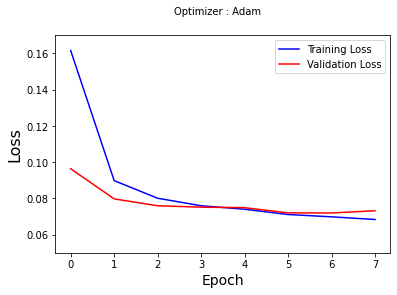

In [16]:
#plotting Loss
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylim(0.05, 0.17)
plt.plot(hist_adam.history['loss'], color='b', label='Training Loss')
plt.plot(hist_adam.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

In [17]:
sequence_length = X_train.shape[1]
filter_sizes = [3,4]
num_filters = 100
drop = 0.4

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)

merged_tensor = concatenate([maxpool_0, maxpool_1], axis=1)
flatten = Flatten()(merged_tensor)
reshape = Reshape((2*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
conc = Dense(40)(dropout)
output = Dense(units=6, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01))(conc)

# this creates a model that includes
model = Model(inputs, output)

# Compiling Model using optimizer
opt = SGD(lr=0.01, momentum=0.9, decay=0.0001)
model.compile(loss='binary_crossentropy',optimizer=opt)

# Fitting Model to the data
callbacks = [EarlyStopping(monitor='val_loss')]
hist_sgd = model.fit(X_train, y_train, batch_size=400, epochs=50, verbose=2, 
                     validation_data=(X_validation, y_validation),callbacks=callbacks)

Epoch 1/50
320/320 - 10s - loss: 0.2050 - val_loss: 0.1374
Epoch 2/50
320/320 - 10s - loss: 0.1169 - val_loss: 0.1044
Epoch 3/50
320/320 - 10s - loss: 0.0963 - val_loss: 0.0931
Epoch 4/50
320/320 - 10s - loss: 0.0883 - val_loss: 0.0883
Epoch 5/50
320/320 - 10s - loss: 0.0843 - val_loss: 0.0852
Epoch 6/50
320/320 - 10s - loss: 0.0818 - val_loss: 0.0833
Epoch 7/50
320/320 - 10s - loss: 0.0799 - val_loss: 0.0818
Epoch 8/50
320/320 - 10s - loss: 0.0784 - val_loss: 0.0806
Epoch 9/50
320/320 - 10s - loss: 0.0770 - val_loss: 0.0796
Epoch 10/50
320/320 - 10s - loss: 0.0761 - val_loss: 0.0787
Epoch 11/50
320/320 - 10s - loss: 0.0752 - val_loss: 0.0779
Epoch 12/50
320/320 - 10s - loss: 0.0744 - val_loss: 0.0774
Epoch 13/50
320/320 - 10s - loss: 0.0738 - val_loss: 0.0767
Epoch 14/50
320/320 - 10s - loss: 0.0729 - val_loss: 0.0761
Epoch 15/50
320/320 - 10s - loss: 0.0725 - val_loss: 0.0757
Epoch 16/50
320/320 - 10s - loss: 0.0720 - val_loss: 0.0752
Epoch 17/50
320/320 - 10s - loss: 0.0714 - val_lo

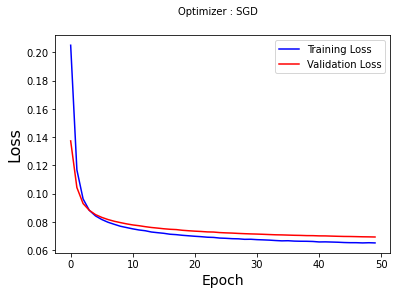

In [18]:
#plotting Loss
plt.suptitle('Optimizer : SGD', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
#plt.ylim(0.05, 0.17)
plt.plot(hist_sgd.history['loss'], color='b', label='Training Loss')
plt.plot(hist_sgd.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

In [19]:
sequence_length = X_train.shape[1]
filter_sizes = [3,4]
num_filters = 100
drop = 0.4

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)

merged_tensor = concatenate([maxpool_0, maxpool_1], axis=1)
flatten = Flatten()(merged_tensor)
reshape = Reshape((2*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
conc = Dense(40)(dropout)
output = Dense(units=6, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01))(conc)

# this creates a model that includes
model = Model(inputs, output)

# Compiling Model using optimizer
opt = Adadelta()
model.compile(loss='binary_crossentropy',optimizer=opt)
# Fitting Model to the data
callbacks = [EarlyStopping(monitor='val_loss')]
hist_adad = model.fit(X_train, y_train, batch_size=1000, epochs=100, verbose=2, 
                      validation_data=(X_validation, y_validation),callbacks=callbacks)

Epoch 1/100
128/128 - 10s - loss: 0.8054 - val_loss: 0.7821
Epoch 2/100
128/128 - 10s - loss: 0.7634 - val_loss: 0.7400
Epoch 3/100
128/128 - 10s - loss: 0.7217 - val_loss: 0.6984
Epoch 4/100
128/128 - 10s - loss: 0.6808 - val_loss: 0.6576
Epoch 5/100
128/128 - 10s - loss: 0.6410 - val_loss: 0.6180
Epoch 6/100
128/128 - 10s - loss: 0.6027 - val_loss: 0.5802
Epoch 7/100
128/128 - 10s - loss: 0.5666 - val_loss: 0.5447
Epoch 8/100
128/128 - 10s - loss: 0.5327 - val_loss: 0.5116
Epoch 9/100
128/128 - 10s - loss: 0.5014 - val_loss: 0.4813
Epoch 10/100
128/128 - 10s - loss: 0.4731 - val_loss: 0.4539
Epoch 11/100
128/128 - 10s - loss: 0.4474 - val_loss: 0.4294
Epoch 12/100
128/128 - 10s - loss: 0.4245 - val_loss: 0.4077
Epoch 13/100
128/128 - 10s - loss: 0.4044 - val_loss: 0.3887
Epoch 14/100
128/128 - 10s - loss: 0.3867 - val_loss: 0.3721
Epoch 15/100
128/128 - 10s - loss: 0.3713 - val_loss: 0.3576
Epoch 16/100
128/128 - 10s - loss: 0.3576 - val_loss: 0.3451
Epoch 17/100
128/128 - 10s - loss

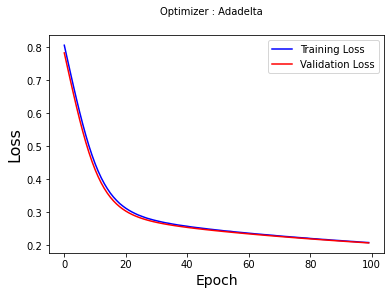

In [20]:
#plotting Loss
plt.suptitle('Optimizer : Adadelta', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
#plt.ylim(0.05, 0.17)
plt.plot(hist_adad.history['loss'], color='b', label='Training Loss')
plt.plot(hist_adad.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

Predict on Test set
---

In [21]:
sequence_length = X_train.shape[1]
filter_sizes = [3,4]
num_filters = 100
drop = 0.4

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)

merged_tensor = concatenate([maxpool_0, maxpool_1], axis=1)
flatten = Flatten()(merged_tensor)
reshape = Reshape((2*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
conc = Dense(40)(dropout)
output = Dense(units=6, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01))(conc)

# this creates a model that includes
model = Model(inputs, output)

In [22]:
# Compiling Model using optimizer
opt = SGD(lr=0.01, momentum=0.9, decay=0.0001)
model.compile(loss='binary_crossentropy',optimizer=opt)

# Fitting Model to the data
callbacks = [EarlyStopping(monitor='val_loss')]
hist_sgd = model.fit(X_train, y_train, batch_size=400, epochs=50, verbose=2, 
                     validation_data=(X_validation, y_validation),callbacks=callbacks)

Epoch 1/50
320/320 - 10s - loss: 0.1999 - val_loss: 0.1333
Epoch 2/50
320/320 - 10s - loss: 0.1143 - val_loss: 0.1025
Epoch 3/50
320/320 - 10s - loss: 0.0950 - val_loss: 0.0920
Epoch 4/50
320/320 - 10s - loss: 0.0877 - val_loss: 0.0874
Epoch 5/50
320/320 - 10s - loss: 0.0838 - val_loss: 0.0848
Epoch 6/50
320/320 - 10s - loss: 0.0816 - val_loss: 0.0830
Epoch 7/50
320/320 - 10s - loss: 0.0799 - val_loss: 0.0815
Epoch 8/50
320/320 - 10s - loss: 0.0784 - val_loss: 0.0805
Epoch 9/50
320/320 - 10s - loss: 0.0770 - val_loss: 0.0796
Epoch 10/50
320/320 - 10s - loss: 0.0762 - val_loss: 0.0789
Epoch 11/50
320/320 - 10s - loss: 0.0754 - val_loss: 0.0781
Epoch 12/50
320/320 - 10s - loss: 0.0746 - val_loss: 0.0774
Epoch 13/50
320/320 - 10s - loss: 0.0739 - val_loss: 0.0768
Epoch 14/50
320/320 - 10s - loss: 0.0732 - val_loss: 0.0763
Epoch 15/50
320/320 - 10s - loss: 0.0729 - val_loss: 0.0760
Epoch 16/50
320/320 - 10s - loss: 0.0723 - val_loss: 0.0754
Epoch 17/50
320/320 - 10s - loss: 0.0718 - val_lo

In [23]:
# convert test to sequence and padding the sequence
sequences_test=tokenizer.texts_to_sequences(test['comment_text'])
X_test = pad_sequences(sequences_test,maxlen=X_train.shape[1])

# Predict on train, val and test datasets
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
pred_val = model.predict(X_validation)

In [24]:
#convert probabilities to labels with threshold 0.75
for j in range(0,6):
    temp = pred_train[:,j]
    for i in range(0,len(temp)):
        if temp[i] > 0.75:
            pred_train[:,j][i] = 1
        else: 
            pred_train[:,j][i] = 0
    
for j in range(0,6):
    temp = pred_test[:,j]
    for i in range(0,len(temp)):
        if temp[i] > 0.75:
            pred_test[:,j][i] = 1
        else: 
            pred_test[:,j][i] = 0
            
for j in range(0,6):
    temp = pred_val[:,j]
    for i in range(0,len(temp)):
        if temp[i] > 0.75:
            pred_val[:,j][i] = 1
        else: 
            pred_val[:,j][i] = 0

In [25]:
from sklearn import metrics
# Creating empty prediction array
col = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
Accuracy = np.zeros((3,6))
for i,x in enumerate(col):
    acc = np.array([metrics.accuracy_score(y_train[:,i], pred_train[:,i]),
                    metrics.accuracy_score(y_validation[:,i], pred_val[:,i]),
                    metrics.accuracy_score(test_y[x], pred_test[:,i])])
    print(x,"Train Accuracy:",acc[0],", Val Accuracy:",acc[1],", Test Accuracy:",acc[2])
    Accuracy[:,i] = acc
    
avg_accuracy = Accuracy.mean(axis=1)
print("Average Train Accuracy:",avg_accuracy[0],
      ", Average Val Accuracy:",avg_accuracy[1],
      ", Average Test Accuracy:",avg_accuracy[2])

toxic Train Accuracy: 0.9526070063295106 , Val Accuracy: 0.9522168259439135 , Test Accuracy: 0.9356341242302041
severe_toxic Train Accuracy: 0.9901532242902801 , Val Accuracy: 0.9903806987310042 , Test Accuracy: 0.9942167620119416
obscene Train Accuracy: 0.9742902801278436 , Val Accuracy: 0.9726147579508069 , Test Accuracy: 0.9641282941010972
threat Train Accuracy: 0.996937080904932 , Val Accuracy: 0.9972740090866363 , Test Accuracy: 0.9967019913095126
insult Train Accuracy: 0.9667465689039293 , Val Accuracy: 0.9657214475951746 , Test Accuracy: 0.9589859014036075
identity_hate Train Accuracy: 0.9911402519270539 , Val Accuracy: 0.9913206955976813 , Test Accuracy: 0.9888242833474007
Average Train Accuracy: 0.978645735413925 , Average Val Accuracy: 0.9782547391508696 , Average Test Accuracy: 0.9730818927339606
